## **Custom CNN model trained on Kaggle dataset**

Trained a note classifier with CNN architecture using an acoustic guitar dataset and perform inference on audio file with trained model.
[Dataset link](https://www.kaggle.com/datasets/mohammedalkooheji/guitar-notes-dataset)
Locally: `dataset`/`Kaggle Dataset`

### Training
- Audio is converted from time-domain to frequency domain using mel_spectogram.
- The mel_spectorgram values are normalized.
- The normalized mel_spectogram values are passed through 4 convolutional blocks, a flatten layer followed by fully connected network of 2 layers.

### Prediction
- Audio is converted again from time-domain to frequency-domain using mel_spectogram.
- Onset detection(detecting when a note is played) is performed using frequency domain data and split into chunks of data. 
- Each chunk is either cropped or padded with 0s until they are of the required input size of the model.
- Inference on model.
- Predicted class is decoded from the model output and shown for each note.

### Conclusion
The results predicted are not as expected, some notes are close while most are completely off.
Both model complexity and dataset have to be improved to better the result. 

### Future improvements
One approach forward could be to improve the dataset and scale up the network to see if performance improves. Another alternative is to reimplementing a different architecture (basic pitch) that can handle onset and note detection in one pipeline with high quality personalised dataset

#### Importing libraries

In [1]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Defining Dataset Class with preprocessing 

In [3]:

# Dataset class for handling loading and preprocessing of the data
class GuitarDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        mel_spectrogram = self.process_audio(file_path)
        mel_spectrogram = torch.from_numpy(mel_spectrogram).float()
        label = torch.tensor(label).long()

        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)
        return mel_spectrogram, label

    def process_audio(self, file_path):
        y, sr = librosa.load(file_path, sr=None)  # Load audio file
        onset_frames = librosa.onset.onset_detect(y=y, sr=sr)  # Detect onsets
        onset_samples = librosa.frames_to_samples(onset_frames)

        # Find the first segment with length > 88000
        selected_segment = None
        for i in range(len(onset_samples)):
            start = onset_samples[i]
            end = onset_samples[i+1] if i+1 < len(onset_samples) else len(y)
            if end - start > 88000:
                selected_segment = y[start:end]
                break

        # If no segment > 88000 found, take the longest segment
        if selected_segment is None:
            longest_segment_length = 0
            for i in range(len(onset_samples)):
                start = onset_samples[i]
                end = onset_samples[i+1] if i+1 < len(onset_samples) else len(y)
                if end - start > longest_segment_length:
                    longest_segment_length = end - start
                    selected_segment = y[start:end]

        # Ensure we have a segment (in case onset detection failed)
        if selected_segment is None:
            selected_segment = y

            # Adjust selected_segment to length 88200
        if len(selected_segment) > 88200:
            selected_segment = selected_segment[:88200]  # Cut if longer
        else:
            padding = np.zeros(88200 - len(selected_segment))
            selected_segment = np.concatenate((selected_segment, padding))
        

        # print("Size of y is: ",len(selected_segment))

        # Generate Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=selected_segment, sr=sr, n_mels=128)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Normalize
        mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())
        return mel_spectrogram_db[np.newaxis, :, :]  # Add channel dimension


#### Define CNN based Model architecture

In [4]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.4)
        
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Flattened layer size calculation
        self.flatten_size = self._get_flatten_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self):
        # Dummy input to calculate size
        x = torch.randn(1, 1, 128, 173)  # Example input size
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout4(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:

# # Function to traverse the dataset folder and load files
# def load_dataset(dataset_path):
#     file_paths = []
#     labels = []

#     for root, dirs, files in os.walk(dataset_path):
#         for subfolder in dirs:
#             subfolder_path = os.path.join(root, subfolder)
#             for file in os.listdir(subfolder_path):
#                 if file.endswith('.wav'):
#                     print(file)
#                     file_paths.append(os.path.join(subfolder_path, file))
#                     labels.append(subfolder)  # Use the folder name as label
    
#     # Encode labels as integers
#     label_encoder = LabelEncoder()
#     encoded_labels = label_encoder.fit_transform(labels)

#     return file_paths, encoded_labels, label_encoder


#### Function to load dataset and perform stratified sampling


In [6]:
def load_dataset_and_split(dataset_path):
    file_paths = []
    labels = []

    for root, dirs, files in os.walk(dataset_path):
        for subfolder in dirs:
            subfolder_path = os.path.join(root, subfolder)
            for file in os.listdir(subfolder_path):
                if file.endswith('.wav'):
                    file_paths.append(os.path.join(subfolder_path, file))
                    labels.append(subfolder)  # Use the folder name as label
    
    # Encode labels as integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Create a dictionary to store file paths for each class
    class_files = defaultdict(list)
    for file_path, label in zip(file_paths, encoded_labels):
        class_files[label].append(file_path)

    # Perform stratified sampling
    train_files = []
    test_files = []
    train_labels = []
    test_labels = []

    for label, files in class_files.items():
        # Select one sample for test set
        test_sample = np.random.choice(files)
        test_files.append(test_sample)
        test_labels.append(label)

        # Add remaining samples to train set
        train_samples = [f for f in files if f != test_sample]
        train_files.extend(train_samples)
        train_labels.extend([label] * len(train_samples))

    return train_files, test_files, np.array(train_labels), np.array(test_labels), label_encoder



#### Train the model


In [7]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [8]:
# # Function to visualize spectrograms for all data points in the dataset
# def visualize_all_spectrograms(dataset):
#     num_samples = len(dataset)
#     fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4 * num_samples))

#     for i in range(num_samples):
#         mel_spectrogram, label = dataset[i]
#         mel_spectrogram = mel_spectrogram.squeeze().numpy()

#         axes[i].imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
#         axes[i].set_title(f"Label: {label.item()}, Shape: {mel_spectrogram.shape}")
#         axes[i].set_xlabel('Time')
#         axes[i].set_ylabel('Mel Frequency')

#     plt.tight_layout()
#     plt.show()


#### Set Dataset path and load dataset

In [ ]:

dataset_path = '/datasets/Kaggle Dataset'  # Root directory containing the dataset
train_files, test_files, train_labels, test_labels, label_encoder = load_dataset_and_split(dataset_path)


#### Initialize dataset and dataloaders

In [10]:
train_dataset = GuitarDataset(train_files, train_labels)
test_dataset = GuitarDataset(test_files, test_labels)


In [11]:

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



#### Define the model


In [12]:
num_classes = len(label_encoder.classes_)
model = CNNModel(num_classes)



#### Train and evaluate the model


In [13]:
train_model(model, train_loader, test_loader, num_epochs=20)


Epoch [1/20], Loss: 3.8209384077050714
Epoch [2/20], Loss: 3.3322957419277577
Epoch [3/20], Loss: 2.766484773560856
Epoch [4/20], Loss: 2.579025088401323
Epoch [5/20], Loss: 2.50613162490759
Epoch [6/20], Loss: 2.3791420647267545
Epoch [7/20], Loss: 2.322460119643908
Epoch [8/20], Loss: 2.2223473948039367
Epoch [9/20], Loss: 2.153310735573929
Epoch [10/20], Loss: 2.1029237147127646
Epoch [11/20], Loss: 2.1095593096165173
Epoch [12/20], Loss: 2.016635233096862
Epoch [13/20], Loss: 1.8757027494773437
Epoch [14/20], Loss: 1.849345313029343
Epoch [15/20], Loss: 1.8022479890437608
Epoch [16/20], Loss: 1.7047358724508392
Epoch [17/20], Loss: 1.6160466255766621
Epoch [18/20], Loss: 1.5977791286586376
Epoch [19/20], Loss: 1.5764851951867007
Epoch [20/20], Loss: 1.4322114265366885
Test Accuracy: 65.12%


#### Save model with model name

In [14]:
torch.save(model.state_dict(), 'model4.pth')


#### Define function to predict notes

In [15]:
def predict_notes(audio_file_path, model, label_encoder):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)
    
    # Detect onsets
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr,
                                          backtrack=False, 
                                          pre_max=100,      # Increase this value
                                          post_max=10,     # Increase this value
                                          pre_avg=100,      # Increase this value
                                          post_avg=50,     # Increase this value
                                          delta=0.1,       # Increase this threshold value
                                          wait=0)
    onset_samples = librosa.frames_to_samples(onset_frames)
    
    # Add the end of the audio as the last onset
    onset_samples = np.append(onset_samples, len(y))

    
    # Optional: Visualize the audio waveform and onset points
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.vlines(librosa.frames_to_time(onset_frames, sr=sr), -1, 1, color='r', linestyle='--', label='Onsets')
    plt.title('Audio Waveform with Detected Onsets')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    
    segments = []
    for i in range(len(onset_samples) - 1):
        start = onset_samples[i]
        end = onset_samples[i + 1]
        
        # Get the segment of the audio
        segment = y[start:end]

        print(f"Size of segment{i} before: ",len(segment))
        
        if len(segment) < 44100:
            continue
        # Crop the segment to 88,200 samples if longer
        if len(segment) > 88200:
            segment = segment[:88200]
        
        # Pad with zeros if the segment length is less than 44,100 samples
        elif len(segment) < 88200:
            padding = 88200 - len(segment)
            segment = np.pad(segment, (0, padding), 'constant')

        print(f"Size of segment{i} after: ",len(segment))
        
        segments.append(segment)

    
    predictions = []
    
    for segment in segments:
        # Generate Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Normalize
        mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())
        
        # Add channel dimension and convert to tensor
        mel_spectrogram_db = torch.from_numpy(mel_spectrogram_db[np.newaxis, :, :]).float()
        
        # Print shape for verification
        print(f"Mel spectrogram shape: {mel_spectrogram_db.shape}")
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(mel_spectrogram_db.unsqueeze(0))  # Add batch dimension
            _, predicted = torch.max(output, 1)
            predicted_label = label_encoder.inverse_transform(predicted.numpy())[0]
            predictions.append(predicted_label)
    
    return predictions


#### Load trained model

In [16]:
model = CNNModel(num_classes=len(label_encoder.classes_))
model.load_state_dict(torch.load('model4.pth'))

C:\Users\Kavitha\AppData\Local\Temp\ipykernel_828\2310939533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model4.pth'))


<All keys matched successfully>


#### Path to your audio file to predict


In [17]:
audio_file_path = 'c-chord.wav'



#### Predict notes


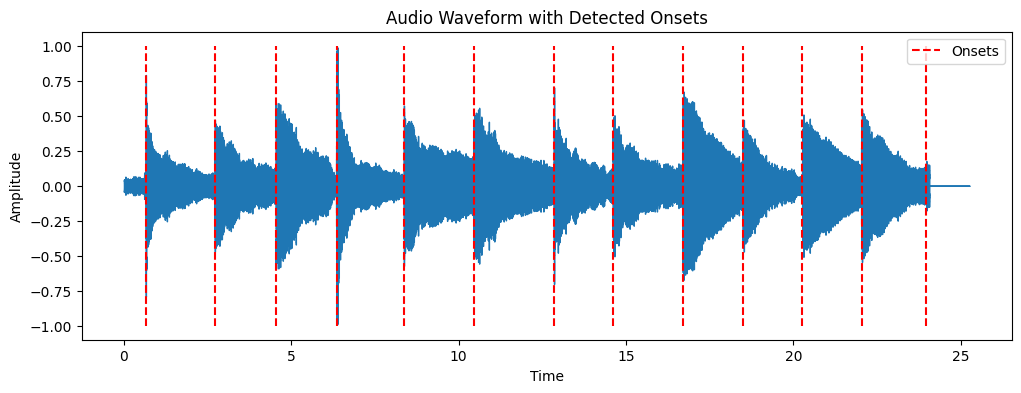

Size of segment0 before:  90624
Size of segment0 after:  88200
Size of segment1 before:  80896
Size of segment1 after:  88200
Size of segment2 before:  79360
Size of segment2 after:  88200
Size of segment3 before:  89088
Size of segment3 after:  88200
Size of segment4 before:  92160
Size of segment4 after:  88200
Size of segment5 before:  105472
Size of segment5 after:  88200
Size of segment6 before:  77824
Size of segment6 after:  88200
Size of segment7 before:  91648
Size of segment7 after:  88200
Size of segment8 before:  79360
Size of segment8 after:  88200
Size of segment9 before:  78336
Size of segment9 after:  88200
Size of segment10 before:  77824
Size of segment10 after:  88200
Size of segment11 before:  84992
Size of segment11 after:  88200
Size of segment12 before:  57212
Size of segment12 after:  88200
Mel spectrogram shape: torch.Size([1, 128, 173])
Mel spectrogram shape: torch.Size([1, 128, 173])
Mel spectrogram shape: torch.Size([1, 128, 173])
Mel spectrogram shape: torc

In [18]:
predicted_notes= predict_notes(audio_file_path, model, label_encoder)



#### Display the list of predicted notes


In [19]:
print("Predicted Notes:")
for i, note in enumerate(predicted_notes):
    print(f"Segment {i+1}: {note}")


Predicted Notes:
Segment 1: Asharp2
Segment 2: Dsharp3
Segment 3: B3
Segment 4: C4
Segment 5: B3
Segment 6: E2
Segment 7: C3
Segment 8: E2
Segment 9: B3
Segment 10: Csharp4
Segment 11: B3
Segment 12: E2
Segment 13: Dsharp3


#### Conclusion


The results predicted are not as expected, some notes are close while most are completely off.
Both model complexity and dataset have to be improved to better the result. 

One approach forward could be to improve the dataset and scale up the network to see if performance improves

Anothe alternative is to reimplementing a different architecture (basic pitch) that can handle onset and note detection in one pipeline with high quality personalised dataset